# **Importing Libraries**

In [193]:
import numpy as np # linear algebra
import pandas as pd # data processing ,csv file Input/Output
import keras
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2 as cv
import tqdm
import io
import os,glob
import ipywidgets as widgets
#from PIL import image
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.models import load_model
from keras.models import Model
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout,GlobalAveragePooling2D
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras import datasets,layers,Sequential
from zipfile import ZipFile
from sklearn import preprocessing
from keras.layers import BatchNormalization
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

# **Installing the libraries**

In [194]:
!pip install tensorflow
!pip install keras

# **Loading Dataset**

In [195]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [196]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [197]:
file = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [198]:
x = []
y = []
labels = ['no','yes']
image_size = 224
for i in labels:
  folderPath = os.path.join('/content/brain_tumor_dataset',i)
  for j in os.listdir(folderPath):
    img_read = cv.imread(os.path.join(folderPath,j))
    img_read = cv.resize(img_read,(image_size,image_size))
    x.append(img_read)
    y.append(i)
x = np.array(x)
y = np.array(y)

In [199]:
x,y = shuffle(x,y,random_state = 101 )

In [200]:
print(f"Shape of X: {x.shape}")
print(f"Shape of Y: {y.shape}")

Shape of X: (253, 224, 224, 3)
Shape of Y: (253,)


In [201]:
print(f"Shape of one example: {x[0].shape}")

Shape of one example: (224, 224, 3)


# **Showing Some Images**

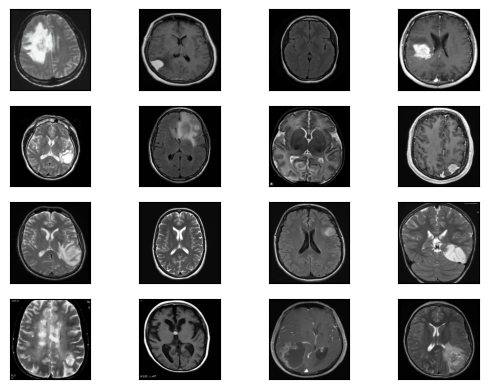

In [202]:
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x[i],cmap=plt.cm.binary)

In [273]:
# # Counting the occurrences of each class label
# unique_labels, label_counts = np.unique(labels, return_counts=True)

# plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
# plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
# plt.xlabel('Class Label')
# plt.ylabel('Count')
# plt.title('Distribution of Class Labels')
# plt.show()

# **Train Test Split**

In [204]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state=42)

In [205]:
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (202, 224, 224, 3)
Shape of x_test: (51, 224, 224, 3)
Shape of y_train: (202,)
Shape of y_test: (51,)


# **Label Encoding**

In [206]:
#for train data
y_train_new = []
for i in y_train:
  y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)
#for test data
y_test_new = []
for i in y_test:
  y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# **Using CNN**

In [207]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation = 'relu',input_shape = (150,150,3)))
model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation = 'relu'))
model.add(Conv2D(128,(3,3),activation = 'relu'))
model.add(Conv2D(128,(3,3),activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(256,(3,3),activation = 'relu'))
model.add(Conv2D(256,(3,3),activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(4,activation = 'softmax'))

In [208]:
print(f"Number of outputs of the model: {model.output_shape[-1]}")

Number of outputs of the model: 4


In [209]:
#y_train = tf.one_hot(y_train, depth=model.output_shape[-1])

In [210]:
#y_train_onehot = to_categorical(y_train, num_classes=4)

In [211]:
#model.layers[-1] = tf.keras.layers.Dense(4, activation='softmax')

In [212]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_46 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 73, 73, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_30 (Dropout)        (None, 73, 73, 64)        0         
                                                                 
 conv2d_47 (Conv2D)          (None, 71, 71, 64)        36928     
                                                                 
 conv2d_48 (Conv2D)          (None, 69, 69, 64)        36928     
                                                      

In [213]:
#model.compile(loss='categorical_crossentropy',optimizer = 'Adam',metrics= ['accuracy'])

In [214]:
#model.fit(x_train,y_train,epochs=20,validation_split=0.1)

# **Using VGG16**

In [215]:
from keras.applications import vgg16

In [216]:
r , c = 224 , 224
vgg = vgg16.VGG16(weights = 'imagenet', include_top = False,input_shape=(r,c,3))

In [217]:
for layer in vgg.layers: #no need to train pre-trained layers
  layer.trainable = False

In [218]:
def vgg_model(bottom_model,claases):
  t_models = bottom_model.output
  t_models = GlobalAveragePooling2D()(t_models)
  t_models = Dense(1024,activation = 'relu')(t_models)
  t_models = Dense(512,activation = 'relu')(t_models)
  t_models = Dense(64,activation = 'relu')(t_models)
  t_models = Dense(32,activation = 'relu')(t_models)
  t_models = Dense(2,activation = 'softmax')(t_models)
  return t_models


# **Building the model**

In [219]:
model_head = vgg_model(vgg,2)
model = Model(inputs = vgg.input,outputs = model_head)

In [220]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [221]:
#print(model.output_shape)

In [222]:
#model.layers[-1].units = y_train.shape[1]

# **Showing the shape of input and output**

In [223]:
# Print the shapes of model input and output
print("Input shape:", model.input_shape)
print("Output shape:", model.output_shape)

Input shape: (None, 224, 224, 3)
Output shape: (None, 2)


In [224]:
# Print the shapes of x_train and y_train
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (202, 224, 224, 3)
y_train shape: (202, 2)


In [225]:
'''
# Print the number of dimensions in y_train
print("y_train dimensions:", y_train.ndim)

# Check if y_train is one-hot encoded
if y_train.ndim == 2 and y_train.shape[1] > 1:
    print("y_train is one-hot encoded.")
else:
    print("y_train is not one-hot encoded.")
'''

'\n# Print the number of dimensions in y_train\nprint("y_train dimensions:", y_train.ndim)\n\n# Check if y_train is one-hot encoded\nif y_train.ndim == 2 and y_train.shape[1] > 1:\n    print("y_train is one-hot encoded.")\nelse:\n    print("y_train is not one-hot encoded.")\n'

In [226]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),metrics = ['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# **Fitting the model**

In [227]:
#model.fit(x_train,y_train,epochs=25,validation_data=(x_test,y_test),initial_epoch=0)
model.fit(x_train,y_train,epochs=25,validation_data=(x_test,y_test),initial_epoch=0)
#model.fit(x_train, y_train_onehot, epochs=25, validation_data=(x_test, y_test), initial_epoch=0)

Epoch 1/25
7/7 [==============================] - 159s 21s/step - loss: 0.6091 - accuracy: 0.6584 - val_loss: 0.5664 - val_accuracy: 0.7059
Epoch 2/25
7/7 [==============================] - 136s 20s/step - loss: 0.3748 - accuracy: 0.8515 - val_loss: 0.5189 - val_accuracy: 0.7647
Epoch 3/25
7/7 [==============================] - 147s 22s/step - loss: 0.2527 - accuracy: 0.9158 - val_loss: 0.4964 - val_accuracy: 0.7843
Epoch 4/25
7/7 [==============================] - 152s 23s/step - loss: 0.1791 - accuracy: 0.9356 - val_loss: 0.4828 - val_accuracy: 0.8235
Epoch 5/25
7/7 [==============================] - 131s 19s/step - loss: 0.1251 - accuracy: 0.9604 - val_loss: 0.5060 - val_accuracy: 0.8431
Epoch 6/25
7/7 [==============================] - 133s 19s/step - loss: 0.0971 - accuracy: 0.9752 - val_loss: 0.4869 - val_accuracy: 0.8431
Epoch 7/25
7/7 [==============================] - 133s 19s/step - loss: 0.0702 - accuracy: 0.9851 - val_loss: 0.5137 - val_accuracy: 0.8431
Epoch 8/25
7/7 [====

# **Seeing the Accuracy in Percentage**

In [228]:
score = model.evaluate(x_test,y_test)

2/2 [==============================] - 26s 10s/step - loss: 0.6833 - accuracy: 0.8627


In [229]:
print(f"Accuracy of the model to detect brain tumor is: {score[1]*100:0.2f}%")

Accuracy of the model to detect brain tumor is: 86.27%


# **Model Accuracy is 86.27%**

# **Making a Prediction**

In [230]:
import random

In [231]:
x.shape

(253, 224, 224, 3)

In [232]:
y.shape

(253,)

In [233]:
index = random.randrange(0,252,1)
print(f"The Random Index is: {index}")

The Random Index is: 69


Image at the index Number: 69: 


Text(0.5, 0, 'yes')

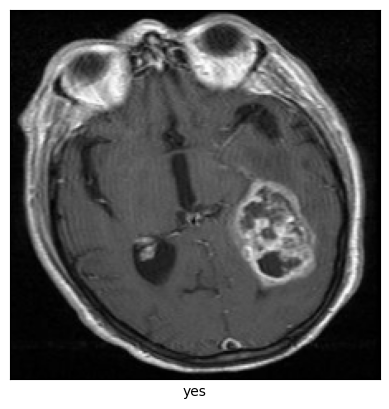

In [234]:
print(f"Image at the index Number: {index}: ")
plt.xticks([])
plt.yticks([])
plt.imshow(x[index],cmap = plt.cm.binary)
plt.xlabel(y[index])

In [235]:
x[index].shape

(224, 224, 3)

In [236]:
x_new = x[index]
x_new =tf.expand_dims(x_new,axis = 0)

In [237]:
pred = model.predict(x_new)

1/1 [==============================] - 1s 946ms/step


In [238]:
pred

array([[2.9898413e-06, 9.9999702e-01]], dtype=float32)

In [239]:
val = np.argmax(pred)

In [240]:
print(f"The Prediction made is: {labels[val]}")

The Prediction made is: yes


# **Making Another Prediction**

In [257]:
index2 = random.randrange(0,252,1)
print(f"The Random Index is: {index2}")

The Random Index is: 53


Image at the index Number: 53: 


Text(0.5, 0, 'yes')

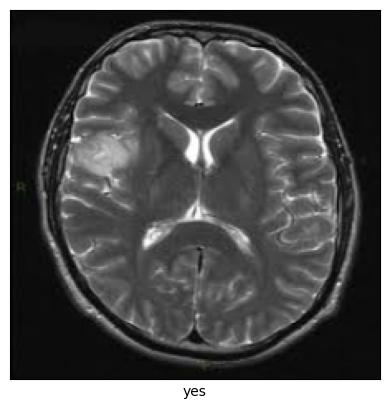

In [258]:
print(f"Image at the index Number: {index2}: ")
plt.xticks([])
plt.yticks([])
plt.imshow(x[index2],cmap = plt.cm.binary)
plt.xlabel(y[index2])

In [243]:
x[index2].shape

(224, 224, 3)

In [244]:
x_new2 = x[index2]
x_new2 =tf.expand_dims(x_new2,axis = 0)

In [245]:
pred2 = model.predict(x_new2)
val2 = np.argmax(pred2) # Get the index of the class with the highest probability

1/1 [==============================] - 0s 491ms/step


In [246]:
print(f"The Prediction made is: {labels[val2]}")

The Prediction made is: yes


# **Using Resnet**

In [247]:
# from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications import resnet50

In [248]:
# Assuming your input image dimensions are 224x224x3
r, c = 224, 224

In [249]:
# Load the ResNet50 model without the top (fully connected) layers
resnet = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(r, c, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [250]:
# Freeze the weights of the ResNet50 layers
for layer in resnet.layers:
    layer.trainable = False

In [251]:
def resnet_model(bottom_model, classes):
    # Define the model head to be added on top of the ResNet50 base
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(64, activation='relu')(top_model)
    top_model = Dense(32, activation='relu')(top_model)
    top_model = Dense(classes, activation='softmax')(top_model)
    return top_model

# **Building the model**

In [252]:
# Build the model
model_head = resnet_model(resnet, 2)  # Assuming 2 classes for binary classification
model = Model(inputs=resnet.input, outputs=model_head)

In [253]:
# Print the model summary
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

# **Compiling the Model**

In [254]:
# Compile the model
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# **Fitting the model**

In [255]:
# Train the model
model.fit(x_train, y_train, epochs=25, validation_data=(x_test, y_test), initial_epoch=0)

Epoch 1/25
7/7 [==============================] - 53s 7s/step - loss: 0.5143 - accuracy: 0.7772 - val_loss: 0.5514 - val_accuracy: 0.7059
Epoch 2/25
7/7 [==============================] - 46s 7s/step - loss: 0.2827 - accuracy: 0.8960 - val_loss: 0.4432 - val_accuracy: 0.8235
Epoch 3/25
7/7 [==============================] - 47s 7s/step - loss: 0.1680 - accuracy: 0.9554 - val_loss: 0.4247 - val_accuracy: 0.8235
Epoch 4/25
7/7 [==============================] - 47s 7s/step - loss: 0.1190 - accuracy: 0.9703 - val_loss: 0.3852 - val_accuracy: 0.8431
Epoch 5/25
7/7 [==============================] - 47s 7s/step - loss: 0.1042 - accuracy: 0.9703 - val_loss: 0.7458 - val_accuracy: 0.7647
Epoch 6/25
7/7 [==============================] - 46s 7s/step - loss: 0.0960 - accuracy: 0.9604 - val_loss: 0.3915 - val_accuracy: 0.8431
Epoch 7/25
7/7 [==============================] - 48s 7s/step - loss: 0.0472 - accuracy: 0.9950 - val_loss: 0.6940 - val_accuracy: 0.8039
Epoch 8/25
7/7 [==================

# **Seeing the Accuracy in Percentage**

In [259]:
score1 = model.evaluate(x_test,y_test)

2/2 [==============================] - 8s 3s/step - loss: 0.7136 - accuracy: 0.8039


In [260]:
print(f"Accuracy of the model to detect brain tumor is: {score1[1]*100:0.2f}%")

Accuracy of the model to detect brain tumor is: 80.39%


# **Making a Prediction**

In [261]:
import random
x.shape
y.shape

(253,)

In [262]:
index = random.randrange(0,252,1)
print(f"The Random Index is: {index}")

The Random Index is: 29


Image at the index Number: 29: 


Text(0.5, 0, 'yes')

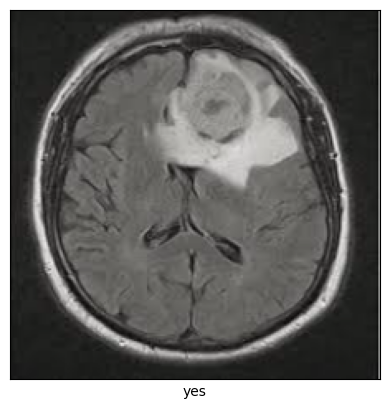

In [263]:
print(f"Image at the index Number: {index}: ")
plt.xticks([])
plt.yticks([])
plt.imshow(x[index],cmap = plt.cm.binary)
plt.xlabel(y[index])

In [265]:
x[index].shape
x_new = x[index]
x_new =tf.expand_dims(x_new,axis = 0)

In [266]:
pred = model.predict(x_new)

1/1 [==============================] - 1s 1s/step


In [267]:
pred
val = np.argmax(pred)
print(f"The Prediction made is: {labels[val]}")

The Prediction made is: yes


# **Making Another Prediction**

In [268]:
index2 = random.randrange(0,252,1)
print(f"The Random Index is: {index2}")

The Random Index is: 119


Image at the index Number: 119: 


Text(0.5, 0, 'no')

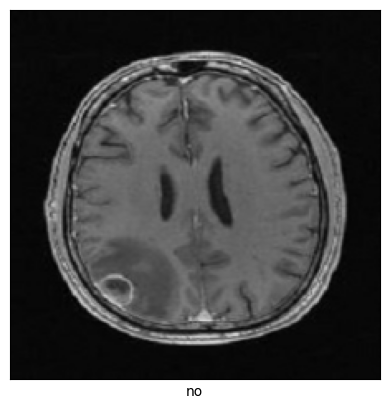

In [270]:
print(f"Image at the index Number: {index2}: ")
plt.xticks([])
plt.yticks([])
plt.imshow(x[index2],cmap = plt.cm.binary)
plt.xlabel(y[index2])

In [271]:
x[index2].shape
x_new2 = x[index2]
x_new2 =tf.expand_dims(x_new2,axis = 0)

In [272]:
pred2 = model.predict(x_new2)
val2 = np.argmax(pred2) # Get the index of the class with the highest probability
print(f"The Prediction made is: {labels[val2]}")

1/1 [==============================] - 0s 199ms/step
The Prediction made is: no
